# Trajectory inference for hematopoiesis in mouse

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import utils as ut
import glob
from sklearn.metrics import classification_report
from scipy.stats import pearsonr
from utils import de_score
import random
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ranksums,ttest_ind


In [21]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

In [22]:
# List all files in the directoty
h5ad_list = glob.glob("F:/ws/pyws/trainsource/saved/adata/review/*.h5ad")

In [23]:
h5ad_list

['F:/ws/pyws/trainsource/saved/adata/review\\GSE1108941214data_GSE110894_drug_I.BET.762_bottle_128_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.01_mod_new_sam_downsampling.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/review\\GSE1122741214data_GSE112274_drug_GEFITINIB_bottle_64_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.1_mod_new_sam_no.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/review\\GSE117872_HN1201214data_GSE117872_HN120_drug_CISPLATIN_bottle_32_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.5_mod_new_sam_SMOTE.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/review\\GSE117872_HN120integratedata_GSE117872_HN120_drug_CISPLATIN_bottle_512_edim_512,256_pdim_128,64_model_DAE_dropout_0.3_gene_T_lr_0.1_mod_new_sam_downsampling.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/review\\GSE117872_HN1371214data_GSE117872_HN137_drug_CISPLATIN_bottle_64_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.1_mod_new_sam_upsampling.h5ad',
 'F:/ws/pyws/train

In [24]:
CELL_TYPE_KEY = {"GSE117872_HN137":"cell_color","GSE117872_HN120":"cell_color","GSE110894":"Sample name","GSE140440":"sensitivity","GSE112274":"sensitivity",
                "GSE149383":"sensitivity"}

In [25]:
h5ad_list

['F:/ws/pyws/trainsource/saved/adata/review\\GSE1108941214data_GSE110894_drug_I.BET.762_bottle_128_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.01_mod_new_sam_downsampling.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/review\\GSE1122741214data_GSE112274_drug_GEFITINIB_bottle_64_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.1_mod_new_sam_no.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/review\\GSE117872_HN1201214data_GSE117872_HN120_drug_CISPLATIN_bottle_32_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.5_mod_new_sam_SMOTE.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/review\\GSE117872_HN120integratedata_GSE117872_HN120_drug_CISPLATIN_bottle_512_edim_512,256_pdim_128,64_model_DAE_dropout_0.3_gene_T_lr_0.1_mod_new_sam_downsampling.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/review\\GSE117872_HN1371214data_GSE117872_HN137_drug_CISPLATIN_bottle_64_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.1_mod_new_sam_upsampling.h5ad',
 'F:/ws/pyws/train

In [26]:
# f= h5ad_list[0]
# adata = sc.read_h5ad(filename=f)
# adata.X.shape

In [27]:
h5ad_list = [h5ad_list[3]]

In [28]:
intested = "GSE117872_HN120"

In [29]:
h5ad_list

['F:/ws/pyws/trainsource/saved/adata/review\\GSE117872_HN120integratedata_GSE117872_HN120_drug_CISPLATIN_bottle_512_edim_512,256_pdim_128,64_model_DAE_dropout_0.3_gene_T_lr_0.1_mod_new_sam_downsampling.h5ad']

In [30]:
h5ad_ae_list = glob.glob("F:/ws/pyws/trainsource/saved/adata/AE/*.h5ad")

In [31]:
h5ad_ae_list

['F:/ws/pyws/trainsource/saved/adata/AE\\GSE110894integrate_data_GSE110894_drug_I.BET.762_bottle_128_edim_512,256_pdim_256,128_model_AE_dropout_0.1_gene_F_lr_0.01_mod_new_sam_downsampling.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/AE\\GSE112274integrate_data_GSE112274_drug_GEFITINIB_bottle_64_edim_512,256_pdim_256,128_model_AE_dropout_0.1_gene_F_lr_0.1_mod_new_sam_no.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/AE\\GSE117872_HN137integrate_data_GSE117872_HN137_drug_CISPLATIN_bottle_64_edim_256,128_pdim_128,64_model_AE_dropout_0.3_gene_F_lr_0.1_mod_new_sam_upsampling.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/AE\\GSE140440integrate_data_GSE140440_drug_DOCETAXEL_bottle_512_edim_256,128_pdim_256,128_model_AE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_no.h5ad',
 'F:/ws/pyws/trainsource/saved/adata/AE\\GSE149383integrate_data_GSE149383_drug_ERLOTINIB_bottle_512_edim_512,256_pdim_256,128_model_AE_dropout_0.1_gene_F_lr_0.1_mod_new_sam_SMOTE.h5ad']

# Generated 3 figures comparing before, after tarnsfer, ground truth

And it will save the F1 score before and after the transfer learning

In [32]:
# Random score test
def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

In [33]:
def p_string(l,score):
    score = sum(l>=score)/len(l)
    if(score==0):
        return "p < 0.001"
    else:
        return "p =" + " "+str(score)

In [34]:
# adata.obs

In [35]:
adata.obs['Sensitive_score']

RHH2177    3287.306641
RHH2178    1823.207642
RHH2179    2730.207764
RHH2180    2420.135254
RHH2181    1514.288330
              ...     
RHH3106     337.113831
RHH3107     272.534546
RHH3108     386.684662
RHH3109     421.168243
RHH3110     482.270386
Name: Sensitive_score, Length: 368, dtype: float32

Index(['cell_color', 'patient_id', 'origin', 'drug_status', 'cluster',
       'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive',
       'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt-',
       'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps',
       'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin',
       'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label',
       'rest_preds'],
      dtype='object')



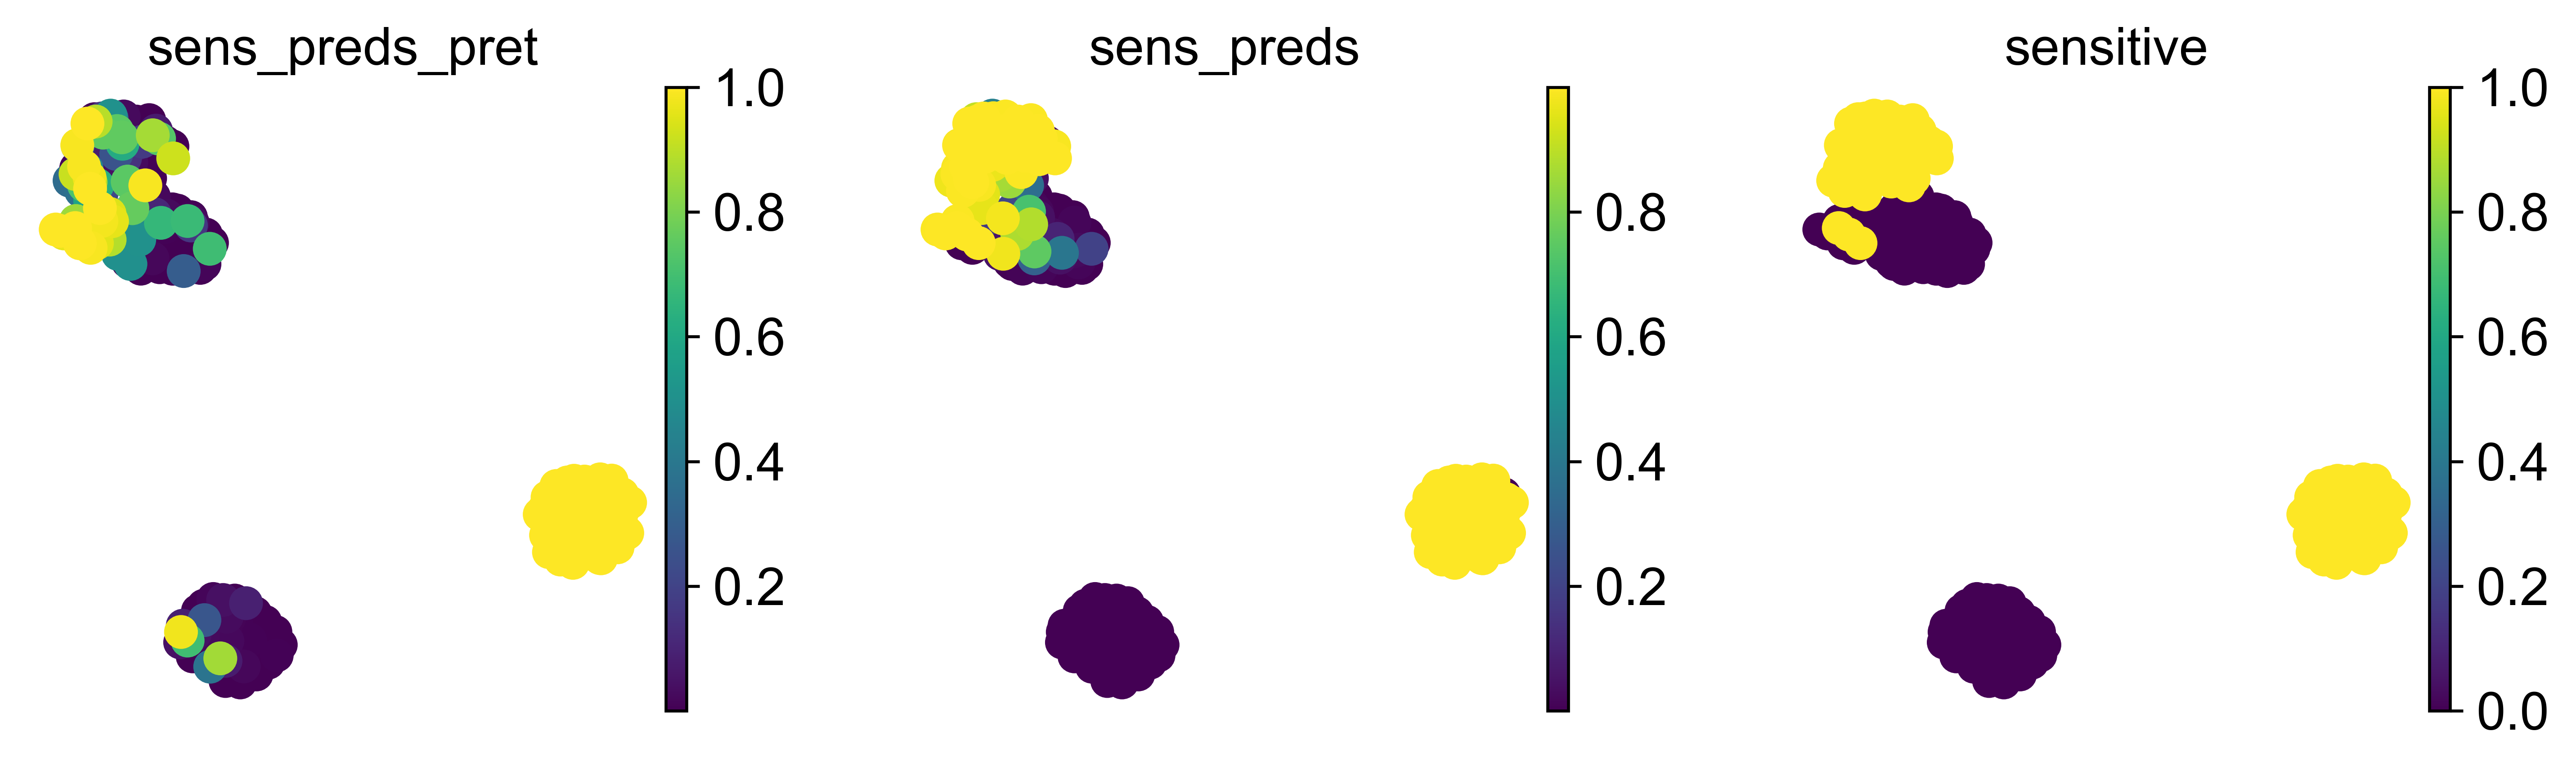

Trying to set attribute `._uns` of view, copying.


In [36]:
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, mean_squared_error,
                             precision_recall_curve, r2_score, roc_auc_score)

names = []
score = []
model = []

interes_adata = None

for f in h5ad_list:
    
    
    adata = sc.read_h5ad(filename=f)
    
    
    if(f.find("117872")>0):
        adata = adata[adata.obs['cluster']!="Holiday"]

    pretrain_label = adata.obs['sens_label_pret']
    sens_label = adata.obs['sens_label']
    
        
    print(adata.obs.columns)

    grouth_truth = adata.obs['sensitive']
    sens_pb_pret = adata.obs['sens_preds_pret']
    sens_label_pret = adata.obs['sens_label_pret']
    sens_pb = adata.obs['sens_preds']

    name = f.split("1214")[0].split("\\")[1]
    
    if(name=="GSE110894"):
        adata=adata[(adata.obs["Sample name"] != "EMPTY") & \
                    (adata.obs["Sample name"] != "EMPTY ") ,: ]
    
    
    
    report_dict_pret = classification_report(grouth_truth, pretrain_label, output_dict=True)
    classification_report_pret_df = pd.DataFrame(report_dict_pret).T
    f1score_pret = report_dict_pret['weighted avg']['f1-score']
    ap_pret = average_precision_score(grouth_truth, sens_pb_pret)
    auroc_pret = roc_auc_score(grouth_truth, sens_label_pret)

    
    report_dict = classification_report(grouth_truth, sens_label, output_dict=True)
    classification_report_df = pd.DataFrame(report_dict).T
    f1score = report_dict['weighted avg']['f1-score']
    ap = average_precision_score(grouth_truth, sens_pb)
    auroc = roc_auc_score(grouth_truth, sens_label)
    
    names.append(name)
    score.append(f1score_pret)
    model.append("before")
    
    names.append(name)
    score.append(f1score)
    model.append("transfer")

    result = pd.DataFrame({"f1":[f1score_pret,f1score],
                          "ap":[ap_pret,ap],
                          "auroc":[auroc_pret,auroc]},index=["pretrain","transfer"])
    
    print()
    # Save the figure
    sc.pl.umap(adata,color=['sens_preds_pret','sens_preds','sensitive'],save="report_compare"+name + '.tiff')
    # Save the f1 score before and after
    result.to_csv("saved/results/report_compare"+name + '.csv')
    
    # Cal pred senstivie score
    adata = ut.de_score(adata,clustername='sens_label')
    
    if(f.find(intested)>0):
        interes_adata = adata

In [37]:
adata=interes_adata

In [38]:
result_compare = pd.DataFrame({"data":names,
                      "transfer":model,
                      "score":score})

In [39]:
adata

AnnData object with n_obs × n_vars = 368 × 7001
    obs: 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', '0_score', '1_score'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Plot the umap highlighting the wrong predictions

In [40]:
idx = adata.obs["sensitive"] != adata.obs["sens_label"]

In [41]:
adata.obs['wrong'] = pd.NA

In [42]:
adata.obs.loc[idx,'wrong'] = "Wrong"
adata.obs['wrong'] = adata.obs.wrong.astype('category')

In [43]:
adata.obs

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,sensitivity,...,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds,0_score,1_score,wrong
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,1,1,0.999998,1,0.999995,1,0.000003,0.317867,3.725890,NaN
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,1,0.999974,1,0.999989,1,0.000008,0.765766,3.285184,NaN
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,1,1.000000,1,0.999995,1,0.000004,0.226617,3.573561,NaN
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,1,0.999999,1,0.999991,1,0.000006,0.459164,3.560009,NaN
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,1,0.999998,1,0.999964,1,0.000026,0.840679,3.321929,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHH3106,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0,0.046830,0,0.885843,1,0.095373,1.820686,1.249644,Wrong
RHH3107,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0,0.107486,0,0.008905,0,0.990175,1.959308,1.084468,NaN
RHH3108,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0,0.000142,0,0.098707,0,0.889611,2.035110,0.809867,NaN
RHH3109,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0,0.679087,1,0.000914,0,0.999037,2.409716,0.965149,NaN


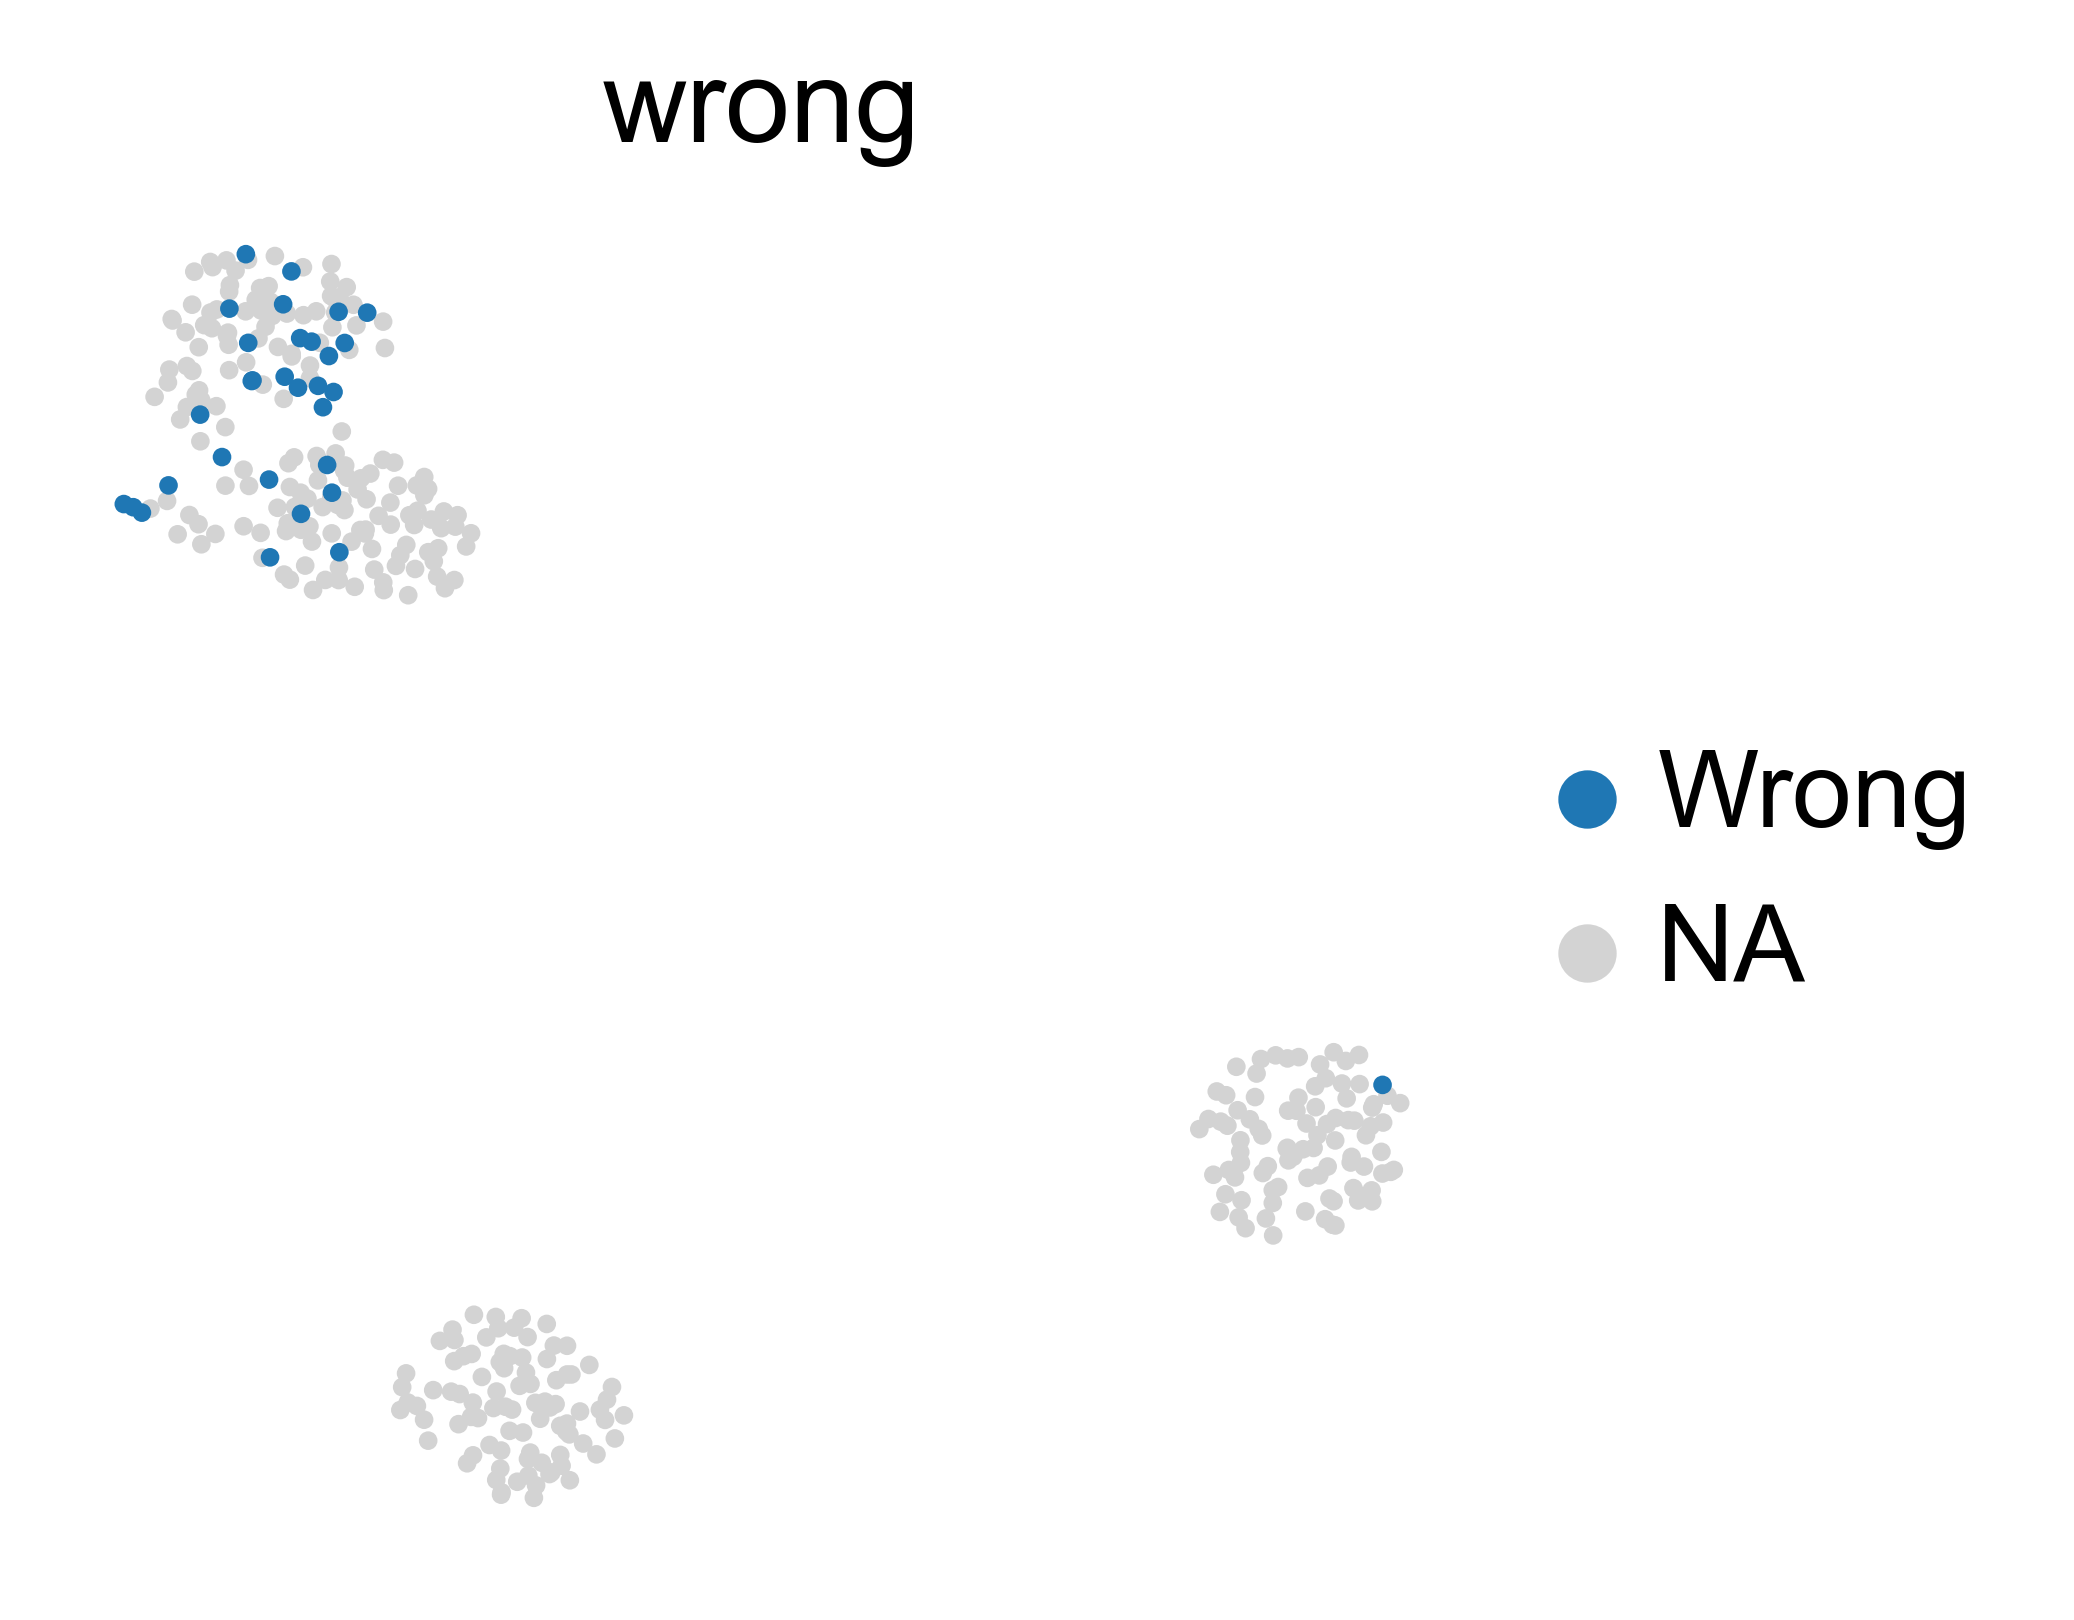

In [44]:
sc.pl.umap(adata,color="wrong",size=20)

In [45]:
name = intested

In [46]:
df = adata.obs[[CELL_TYPE_KEY[name],"wrong"]]\
.groupby([CELL_TYPE_KEY[name]])\
.aggregate(['count','size'])\
.reset_index()
df['data'] = name
df

cell_color wrong                  data
             count size                 
0     HN120M    19   91  GSE117872_HN120
1   HN120MCR     8   92  GSE117872_HN120
2     HN120P     1   90  GSE117872_HN120
3   HN120PCR     3   95  GSE117872_HN120

In [47]:
result_compare

,data,transfer,score
0,GSE117872_HN120integratedata_GSE117872_HN120_d...,before,0.748073
1,GSE117872_HN120integratedata_GSE117872_HN120_d...,transfer,0.915677


# Barplot of score before and after the transfer

In [48]:

# sc.settings.set_figure_params(dpi=800, frameon=False, figsize=(5, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
# g = sns.barplot(x="data", y="score",hue="transfer",palette="Greens_r",
#                 data=result_compare)
# plt.legend().remove()
# sns.despine(bottom = True, left = True)

# plt.setp(g.get_xticklabels(), rotation=-45)

# Figure 2 A panel

In [49]:
adata.obs

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,sensitivity,...,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds,0_score,1_score,wrong
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,1,1,0.999998,1,0.999995,1,0.000003,0.317867,3.725890,NaN
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,1,0.999974,1,0.999989,1,0.000008,0.765766,3.285184,NaN
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,1,1.000000,1,0.999995,1,0.000004,0.226617,3.573561,NaN
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,1,0.999999,1,0.999991,1,0.000006,0.459164,3.560009,NaN
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,1,0.999998,1,0.999964,1,0.000026,0.840679,3.321929,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHH3106,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0,0.046830,0,0.885843,1,0.095373,1.820686,1.249644,Wrong
RHH3107,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0,0.107486,0,0.008905,0,0.990175,1.959308,1.084468,NaN
RHH3108,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0,0.000142,0,0.098707,0,0.889611,2.035110,0.809867,NaN
RHH3109,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0,0.679087,1,0.000914,0,0.999037,2.409716,0.965149,NaN


In [50]:
adata.obs["pred_binary"] = adata.obs["sens_label"]
adata.obs.sens_label = adata.obs.sens_label.cat.rename_categories({1:"Sensitive", 0:"Resistant"})

In [51]:
#adata.obs.sensitivity = adata.obs.sensitivity.cat.rename_categories({"Sensitive":"Response", "Resistant":"Resistant"})

In [52]:
adata.obs=adata.obs.rename(columns={"sensitivity": "Ground Truth", "sens_label": "Prediction"})

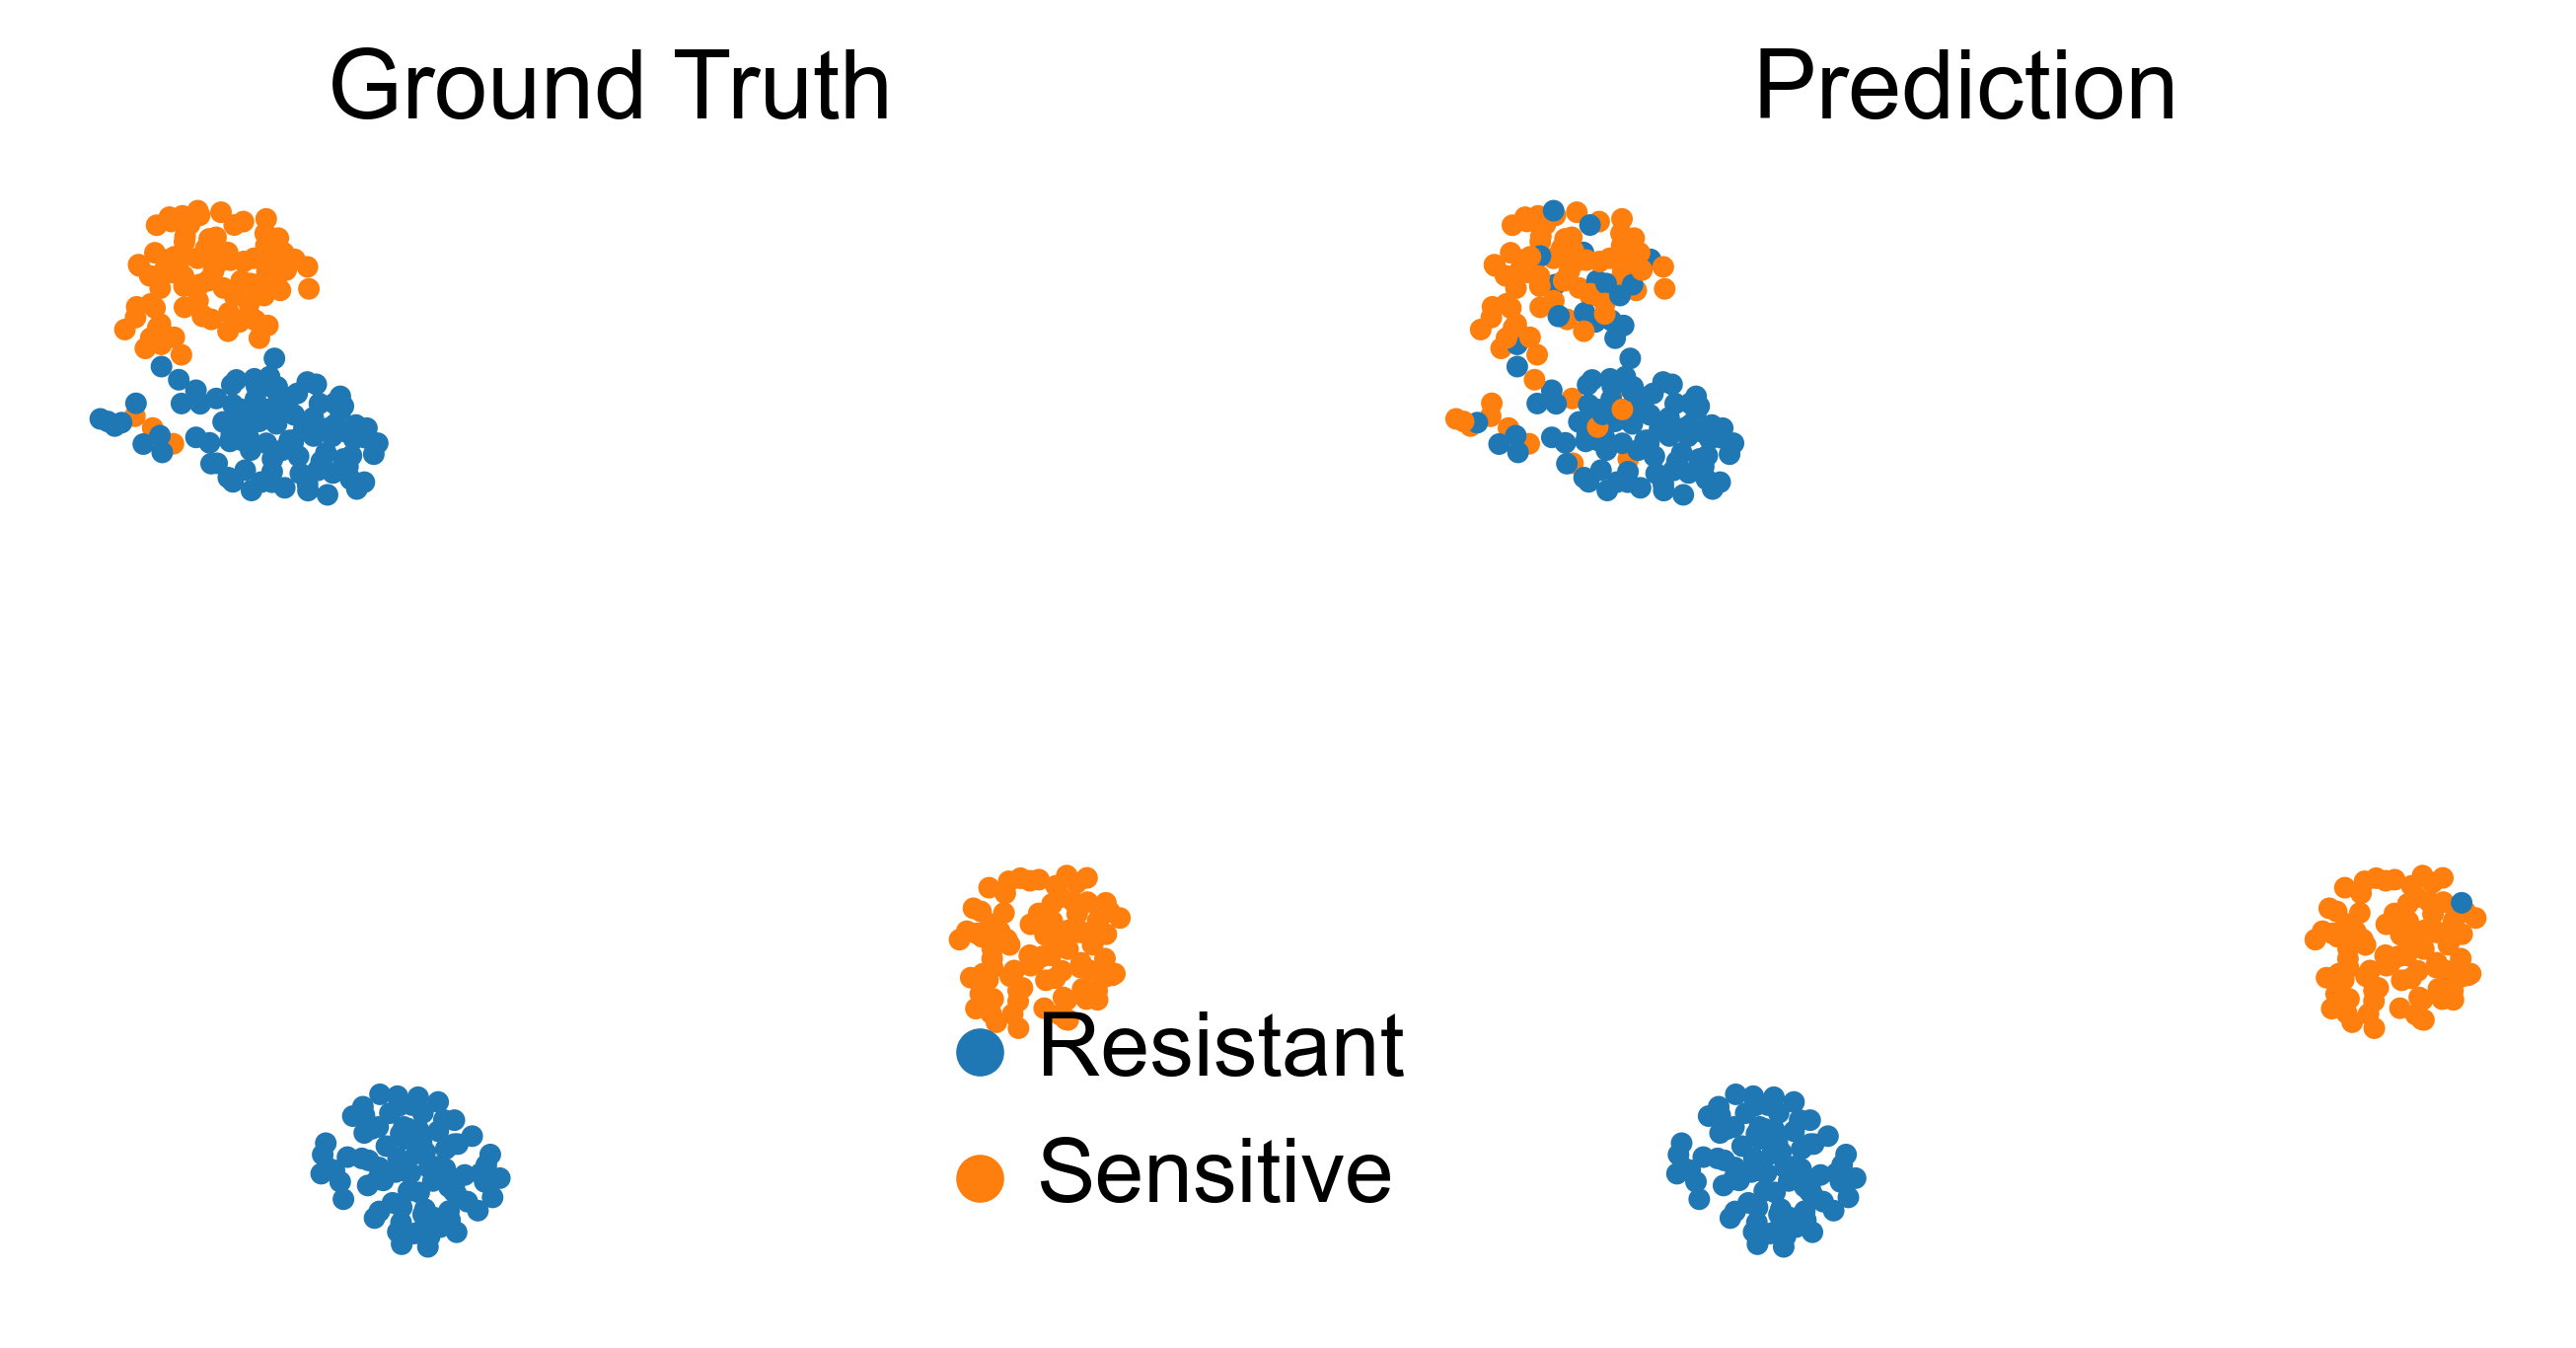

In [53]:
sc.settings.set_figure_params(dpi=250, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction"],size=40,show=False,wspace=0.1)
ax[0].legend().remove()
ax[1].legend(loc ='lower center',bbox_to_anchor=(-0.2, 0),frameon=False) 
plt.savefig("saved/figures/figure2A_1"+name + ".tiff")

In [54]:
adata.obs

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,Ground Truth,...,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,Prediction,rest_preds,0_score,1_score,wrong,pred_binary
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,1,0.999998,1,0.999995,Sensitive,0.000003,0.317867,3.725890,NaN,1
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,0.999974,1,0.999989,Sensitive,0.000008,0.765766,3.285184,NaN,1
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,1.000000,1,0.999995,Sensitive,0.000004,0.226617,3.573561,NaN,1
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,0.999999,1,0.999991,Sensitive,0.000006,0.459164,3.560009,NaN,1
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1,0.999998,1,0.999964,Sensitive,0.000026,0.840679,3.321929,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHH3106,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0.046830,0,0.885843,Sensitive,0.095373,1.820686,1.249644,Wrong,1
RHH3107,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0.107486,0,0.008905,Resistant,0.990175,1.959308,1.084468,NaN,0
RHH3108,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0.000142,0,0.098707,Resistant,0.889611,2.035110,0.809867,NaN,0
RHH3109,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0.679087,1,0.000914,Resistant,0.999037,2.409716,0.965149,NaN,0


In [55]:
try:
    adata.obs["Sample name"] = adata.obs["cell_color"]
except:
    adata.obs["Sample name"] = adata.obs["Ground Truth"]

In [56]:
name

'GSE117872_HN120'

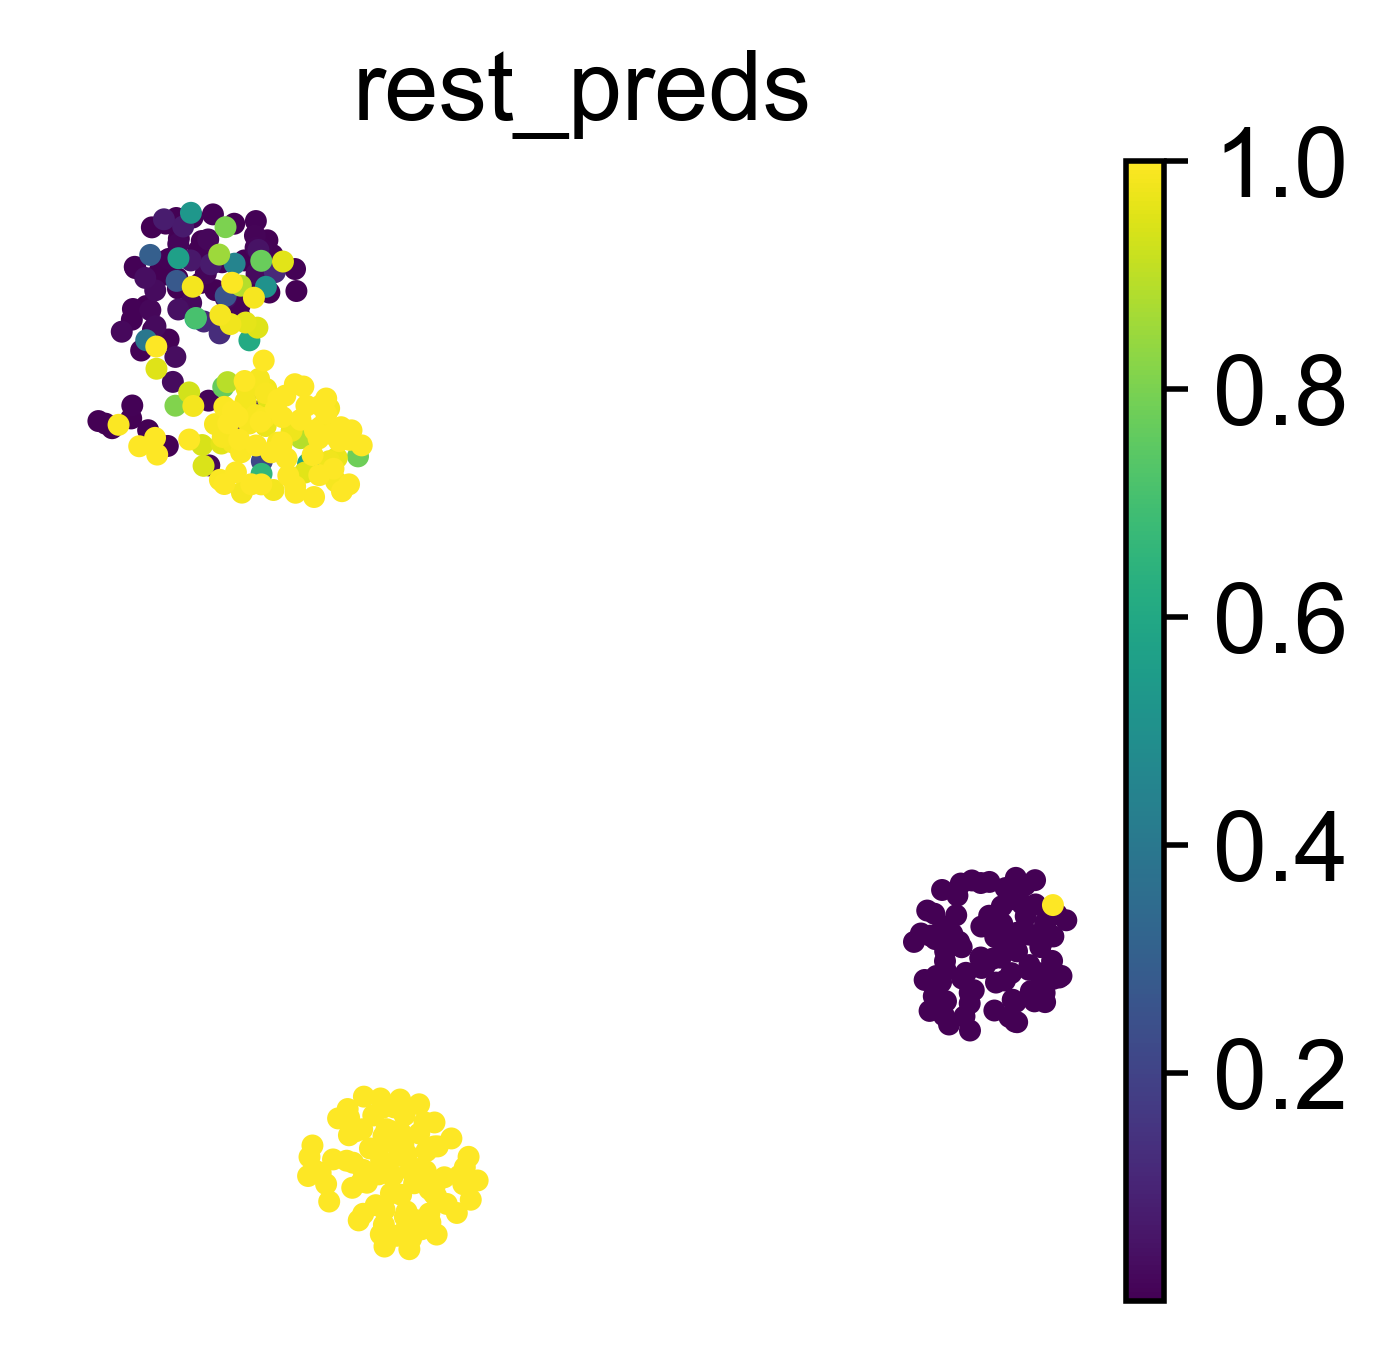

In [57]:
ax = sc.pl.umap(adata,color=["rest_preds"],size=40,palette="Paired",show=False)
plt.savefig("saved/figures/figure2A_2"+name + ".tiff")

In [58]:
adata.obs["Sample name"]

RHH2177      HN120P
RHH2178      HN120P
RHH2179      HN120P
RHH2180      HN120P
RHH2181      HN120P
             ...   
RHH3106    HN120MCR
RHH3107    HN120MCR
RHH3108    HN120MCR
RHH3109    HN120MCR
RHH3110    HN120MCR
Name: Sample name, Length: 368, dtype: category
Categories (4, object): ['HN120M', 'HN120MCR', 'HN120P', 'HN120PCR']

In [59]:
# if(intested=="GSE117872_HN137"):
#     adata.obs["Sample name"] =adata.obs["Sample name"].cat.rename_categories({'HN137M':"Metastasis sensitive cells", \
#                                                     "HN137MCR":"Metastasis resistant cells",\
#                                                   'HN137P':"Primary site sensitive cells",\
#                                                   "HN137PCR":"Primary site resistant cells",\
#                                                    })


In [60]:
# if(intested=="GSE117872_HN120"):
#     adata.obs["Sample name"] =adata.obs["Sample name"].cat.rename_categories({'HN120M':"Metastasis sensitive cells", \
#                                                     "HN120MCR":"Metastasis resistant cells",\
#                                                   'HN120P':"Primary site sensitive cells",\
#                                                   "HN120PCR":"Primary site resistant cells",\
#                                                    })

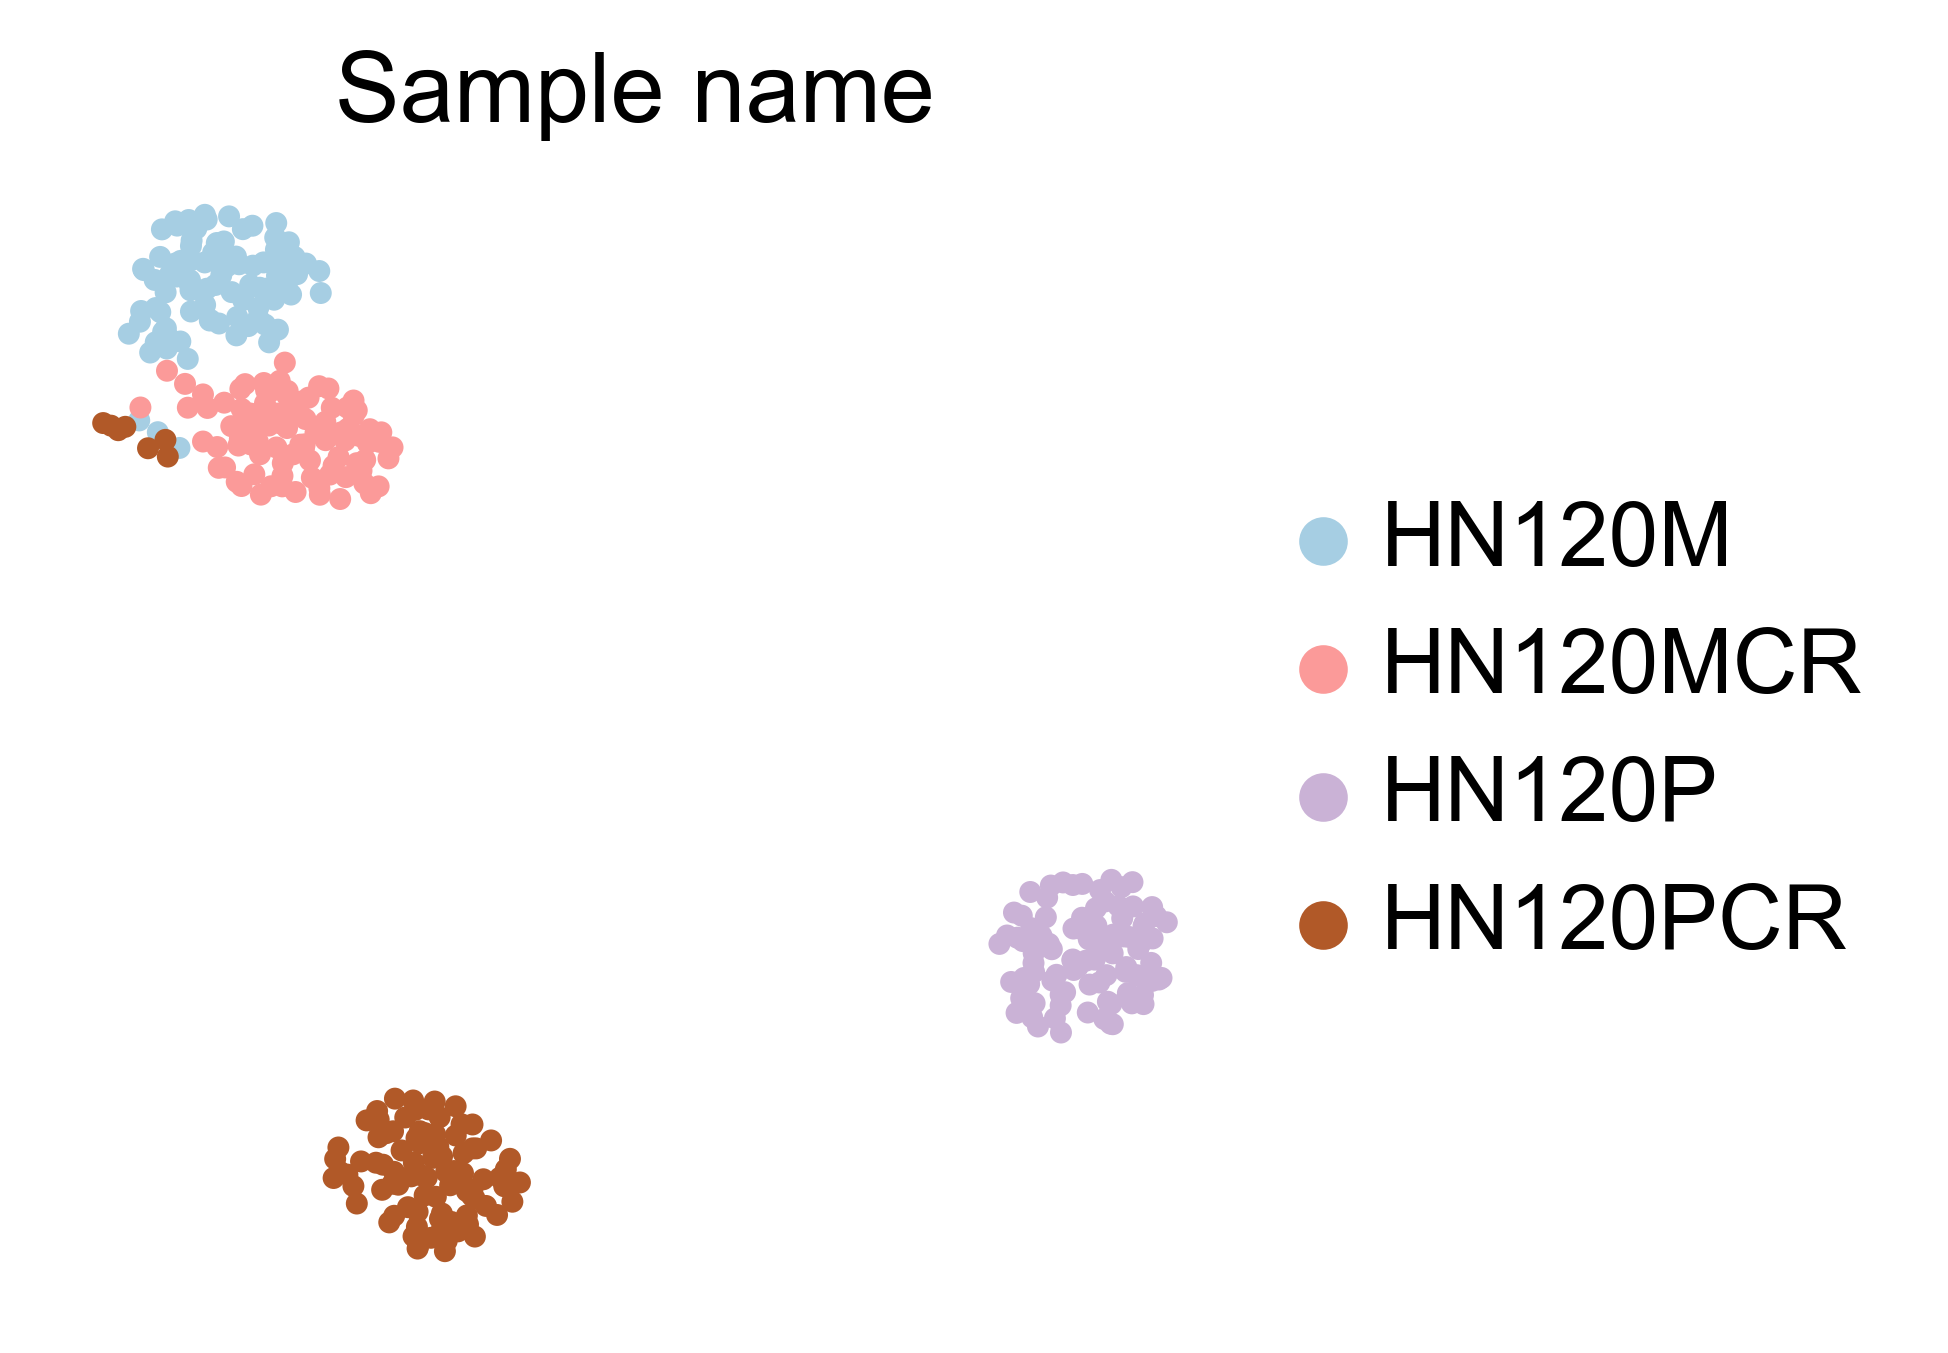

In [61]:
ax = sc.pl.umap(adata,color=["Sample name"],size=40,palette="Paired",show=False)
# ax.legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
plt.savefig("saved/figures/figure2A_3"+name + ".tiff")

In [62]:
# adata.obs.loc[adata.obs.drug_status=="Metastatic","sensitive"] = 0

# adata.obs.loc[adata.obs.drug_status=="Metastatic","Ground Truth"] = "Resistant"

In [63]:
adata.obs

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,Ground Truth,...,sens_preds_pret,sens_label_pret,sens_preds,Prediction,rest_preds,0_score,1_score,wrong,pred_binary,Sample name
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,0.999998,1,0.999995,Sensitive,0.000003,0.317867,3.725890,NaN,1,HN120P
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,0.999974,1,0.999989,Sensitive,0.000008,0.765766,3.285184,NaN,1,HN120P
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1.000000,1,0.999995,Sensitive,0.000004,0.226617,3.573561,NaN,1,HN120P
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,0.999999,1,0.999991,Sensitive,0.000006,0.459164,3.560009,NaN,1,HN120P
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,0.999998,1,0.999964,Sensitive,0.000026,0.840679,3.321929,NaN,1,HN120P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHH3106,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.046830,0,0.885843,Sensitive,0.095373,1.820686,1.249644,Wrong,1,HN120MCR
RHH3107,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.107486,0,0.008905,Resistant,0.990175,1.959308,1.084468,NaN,0,HN120MCR
RHH3108,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.000142,0,0.098707,Resistant,0.889611,2.035110,0.809867,NaN,0,HN120MCR
RHH3109,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.679087,1,0.000914,Resistant,0.999037,2.409716,0.965149,NaN,0,HN120MCR


In [64]:
# report_df = {}
# Y_test = adata.obs['sensitive']
# sens_pb_results = adata.obs['sens_preds']
# lb_results = adata.obs['pred_binary']

# #Y_test ture label
# ap_score = average_precision_score(Y_test, sens_pb_results)
# # ap_umap = average_precision_score(Y_test, sens_pb_umap)
# # ap_tsne = average_precision_score(Y_test, sens_pb_tsne)

# roc_score = roc_auc_score(Y_test, sens_pb_results)

# report_dict = classification_report(Y_test, lb_results, output_dict=True)
# f1score = report_dict['weighted avg']['f1-score']

In [65]:
adata.obs

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,Ground Truth,...,sens_preds_pret,sens_label_pret,sens_preds,Prediction,rest_preds,0_score,1_score,wrong,pred_binary,Sample name
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,0.999998,1,0.999995,Sensitive,0.000003,0.317867,3.725890,NaN,1,HN120P
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,0.999974,1,0.999989,Sensitive,0.000008,0.765766,3.285184,NaN,1,HN120P
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1.000000,1,0.999995,Sensitive,0.000004,0.226617,3.573561,NaN,1,HN120P
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,0.999999,1,0.999991,Sensitive,0.000006,0.459164,3.560009,NaN,1,HN120P
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,0.999998,1,0.999964,Sensitive,0.000026,0.840679,3.321929,NaN,1,HN120P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHH3106,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.046830,0,0.885843,Sensitive,0.095373,1.820686,1.249644,Wrong,1,HN120MCR
RHH3107,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.107486,0,0.008905,Resistant,0.990175,1.959308,1.084468,NaN,0,HN120MCR
RHH3108,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.000142,0,0.098707,Resistant,0.889611,2.035110,0.809867,NaN,0,HN120MCR
RHH3109,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.679087,1,0.000914,Resistant,0.999037,2.409716,0.965149,NaN,0,HN120MCR


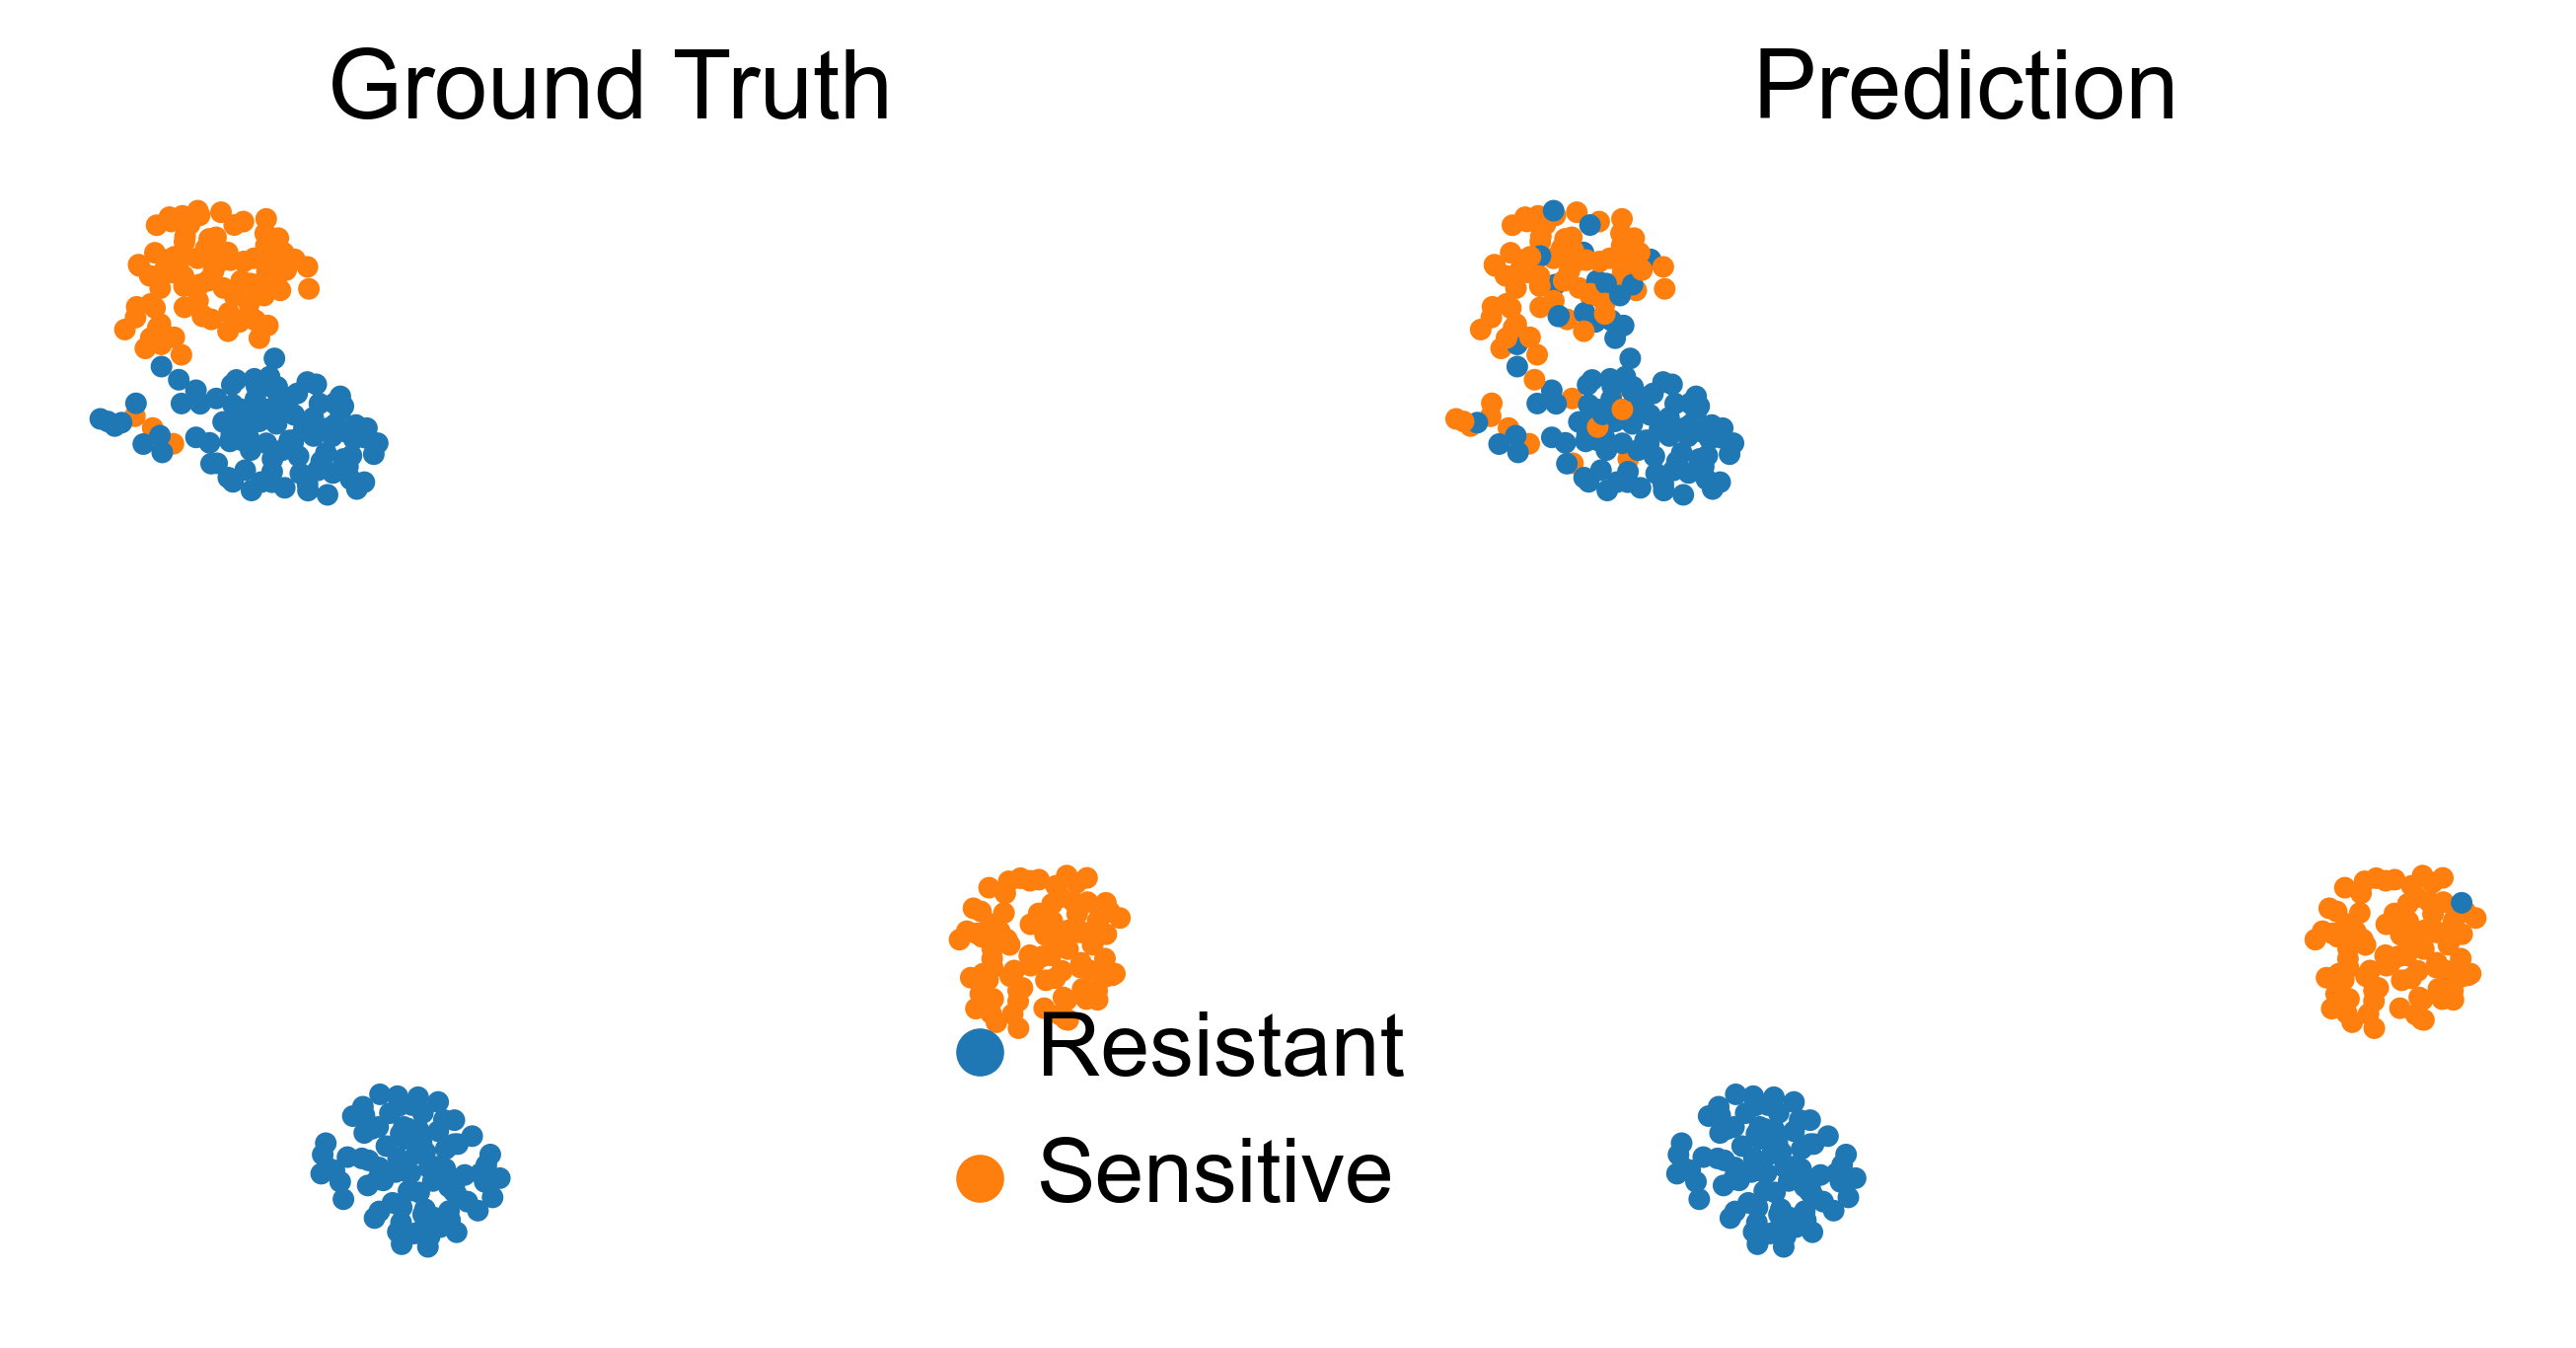

In [66]:
sc.settings.set_figure_params(dpi=250, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction"],size=40,show=False,wspace=0.1)
ax[0].legend().remove()
ax[1].legend(loc ='lower center',bbox_to_anchor=(-0.2, 0),frameon=False) 
plt.savefig("saved/figures/figure2A_1"+name + ".tiff")

In [67]:
report_dict

{'0': {'precision': 0.8979591836734694,
  'recall': 0.9411764705882353,
  'f1-score': 0.9190600522193212,
  'support': 187},
 '1': {'precision': 0.936046511627907,
  'recall': 0.8895027624309392,
  'f1-score': 0.9121813031161473,
  'support': 181},
 'accuracy': 0.9157608695652174,
 'macro avg': {'precision': 0.9170028476506882,
  'recall': 0.9153396165095873,
  'f1-score': 0.9156206776677343,
  'support': 368},
 'weighted avg': {'precision': 0.9166923531293204,
  'recall': 0.9157608695652174,
  'f1-score': 0.9156767544267275,
  'support': 368}}

In [68]:
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction","Sample name"],size=25,palette="Paired",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[2].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.5)) 
plt.savefig("figure2A_compare"+name + ".tiff")
plt.close()

In [69]:
adata.obs.columns

Index(['cell_color', 'patient_id', 'origin', 'drug_status', 'cluster',
       'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive',
       'Ground Truth', 'Resistant_score', 'Sensitive_score', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt-',
       'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps',
       'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin',
       'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'Prediction',
       'rest_preds', '0_score', '1_score', 'wrong', 'pred_binary',
       'Sample name'],
      dtype='object')

In [70]:
adata = ut.de_score(adata,clustername='pred_binary')

In [71]:
adata.obs

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,Ground Truth,...,sens_preds_pret,sens_label_pret,sens_preds,Prediction,rest_preds,0_score,1_score,wrong,pred_binary,Sample name
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,0.999998,1,0.999995,Sensitive,0.000003,0.317867,3.725890,NaN,1,HN120P
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,0.999974,1,0.999989,Sensitive,0.000008,0.765766,3.285184,NaN,1,HN120P
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,1.000000,1,0.999995,Sensitive,0.000004,0.226617,3.573561,NaN,1,HN120P
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,0.999999,1,0.999991,Sensitive,0.000006,0.459164,3.560009,NaN,1,HN120P
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,0.999998,1,0.999964,Sensitive,0.000026,0.840679,3.321929,NaN,1,HN120P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHH3106,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.046830,0,0.885843,Sensitive,0.095373,1.820686,1.249644,Wrong,1,HN120MCR
RHH3107,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.107486,0,0.008905,Resistant,0.990175,1.959308,1.084468,NaN,0,HN120MCR
RHH3108,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.000142,0,0.098707,Resistant,0.889611,2.035110,0.809867,NaN,0,HN120MCR
RHH3109,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0.679087,1,0.000914,Resistant,0.999037,2.409716,0.965149,NaN,0,HN120MCR


In [72]:
sens_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
resistant_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])

In [73]:
ax = sc.pl.umap(adata,color=["1_score","Sensitive_score"],size=40,palette="Set2",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
plt.savefig("saved/figures/figure2A_4"+name + ".tiff")
plt.clf()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1905x750 with 0 Axes>

In [74]:
ax = sc.pl.umap(adata,color=["0_score","Resistant_score"],size=40,palette="flare",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
plt.savefig("saved/figures/figure2A_5"+name + ".tiff")
plt.clf()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1905x750 with 0 Axes>

In [75]:

def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

In [76]:
adata,s_ran, s_score,s_pval ,r_ran,r_score,r_pval = ran_test_score(adata,2)

In [77]:
r_ran

[-0.23832062365476897, -0.449636947701353]

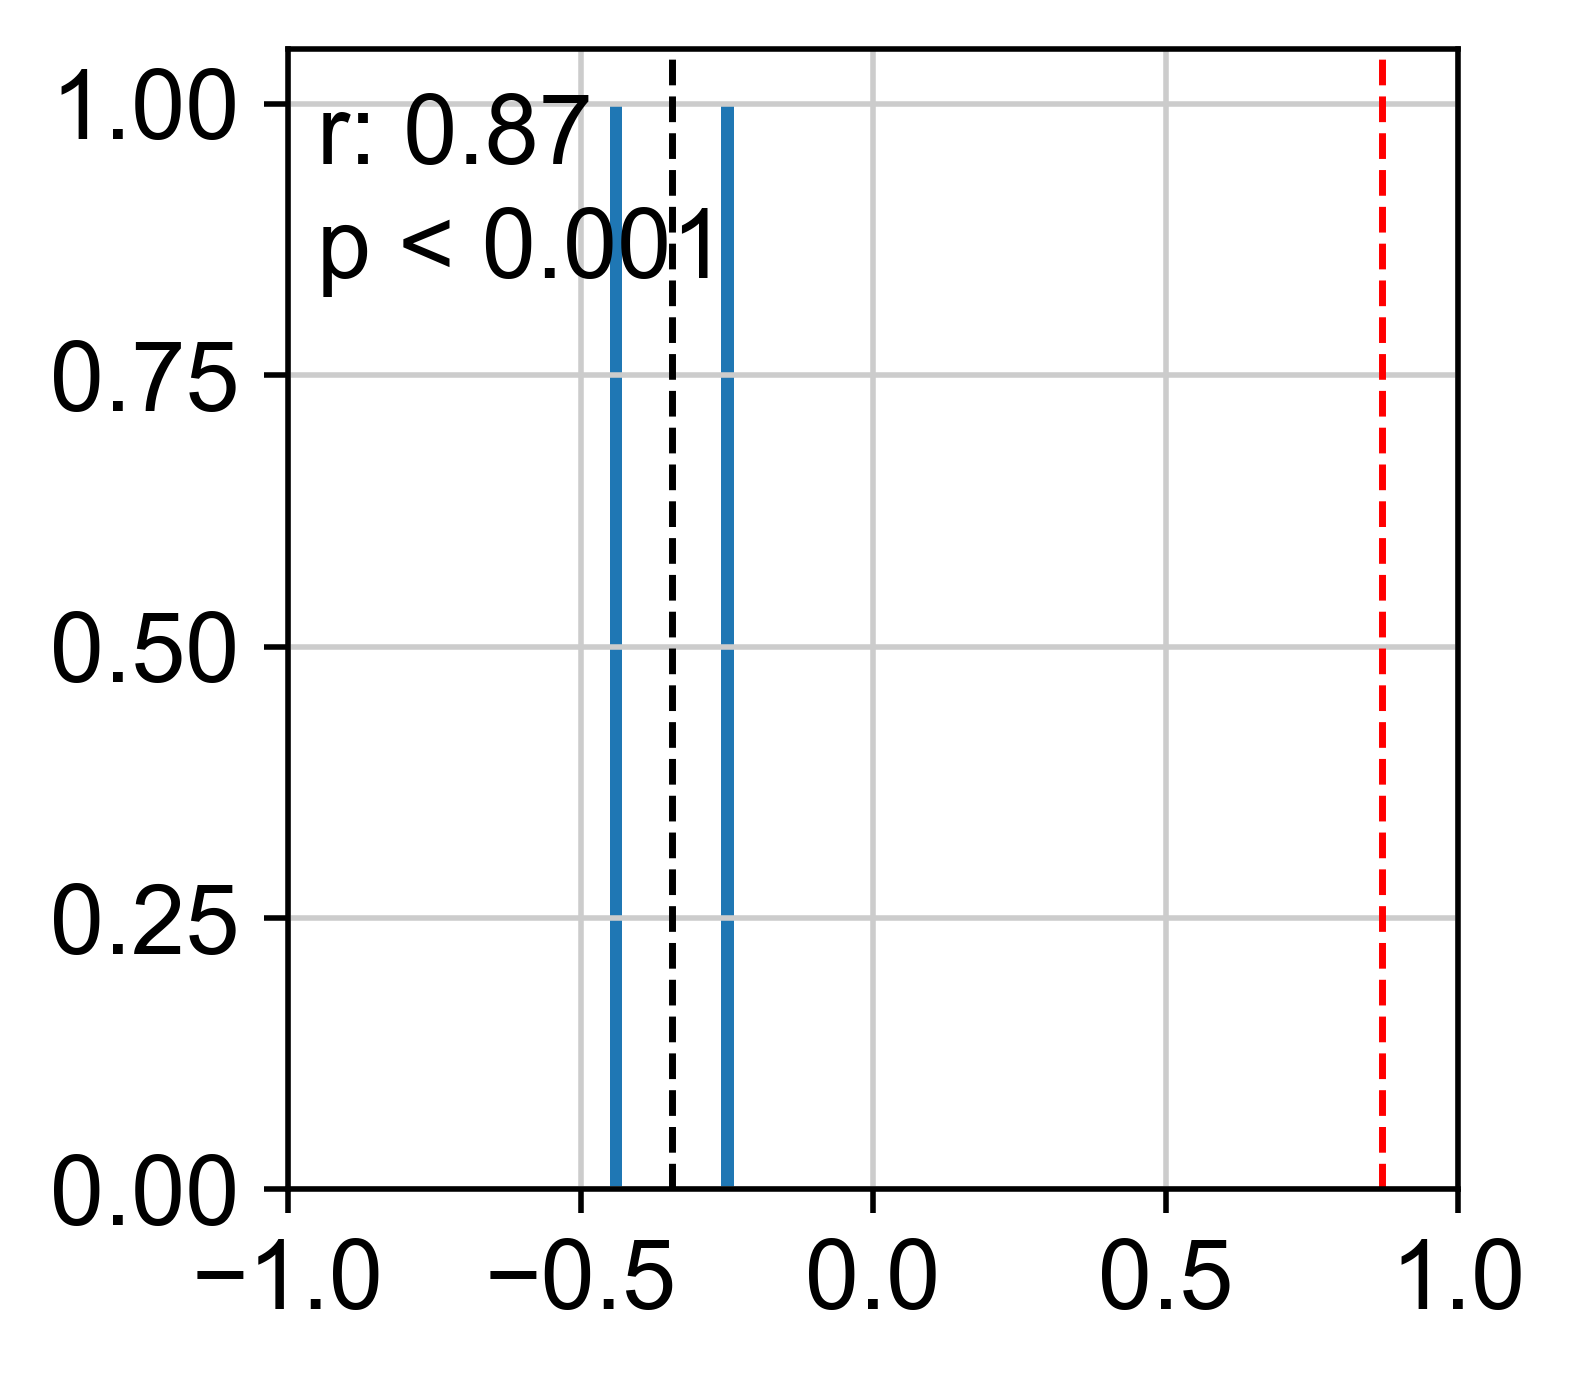

In [78]:
plt.hist(r_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(r_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(r_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(r_score), color='k')
plt.show()

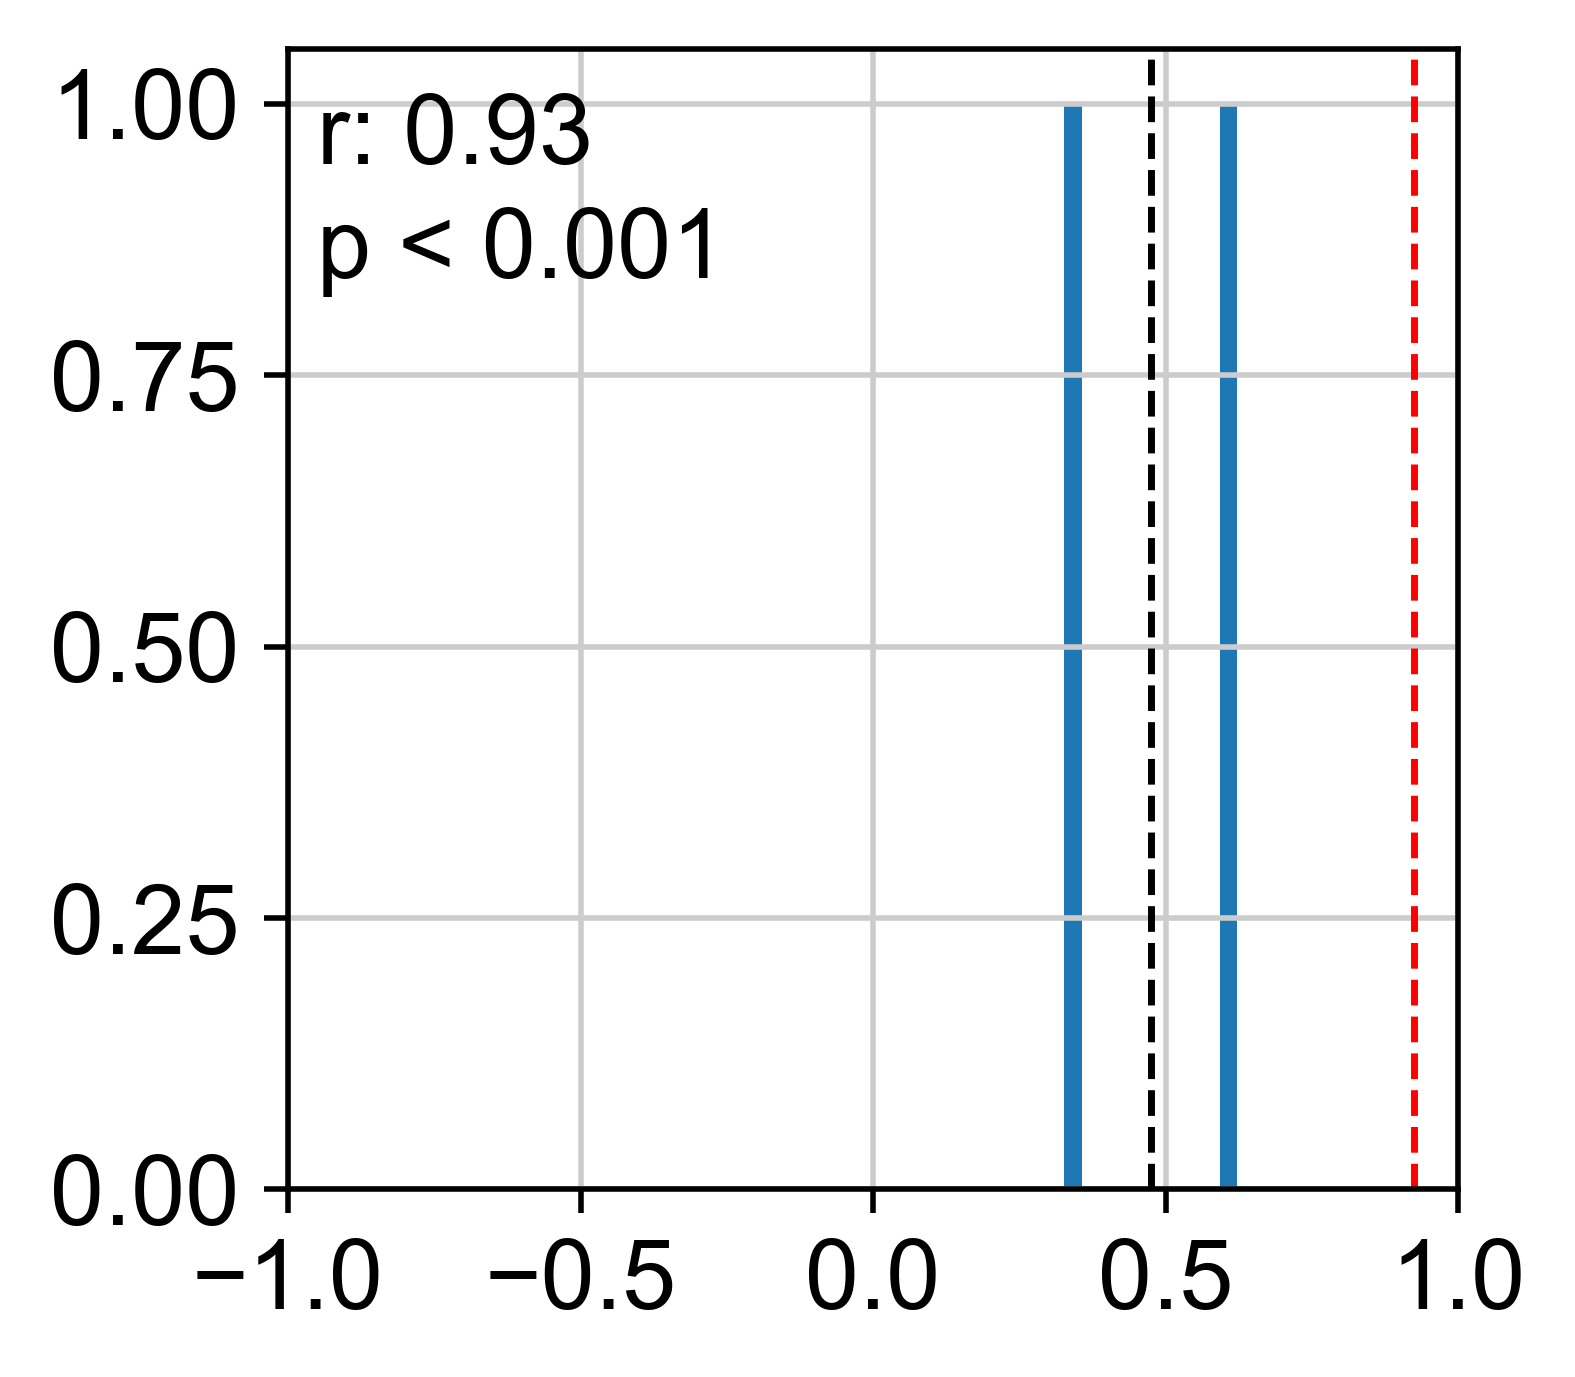

In [79]:
plt.hist(s_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(s_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(s_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(s_score), color='k')
plt.savefig("saved/figures/random_senstive_gene"+name + '.svg')
plt.show()

In [80]:
#scaler.fit_transform(score_1.reshape(1, -1)).ravel()

In [81]:
import scipy as sp
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid")

# score_1 = ig[flagnz_ig & flagnz_exp]
# score_2 = exp[flagnz_ig & flagnz_exp]


#c = adata.obs.loc[flagnz_ig,"sensitivity"].values

score_1 = adata.obs.loc[:,'Sensitive_score'].ravel()
score_2 = adata.obs.loc[:,'1_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values


scaler = MinMaxScaler()

# score_1 =scaler.fit_transform(score_1.reshape(1, -1)).ravel()
# score_2 =scaler.fit_transform(score_2.reshape(1, -1)).ravel()



# score_1 = np.clip(score_1,np.percentile(score_1, 5),np.percentile(score_1, 95))
# score_2 = np.clip(score_2,np.percentile(score_2, 5),np.percentile(score_2, 95))

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)
)

# Use regplot to plot the regression line and use line_kws to set line label for legend
#ax = sns.regplot(x="x", y="y", data=DF_0, scatter_kws={"zorder":-1},

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
plt.savefig("saved/figures/Regplot_sesistive_"+name+".tiff")
plt.clf()


<Figure size 1000x1000 with 0 Axes>

In [82]:
score_1 = adata.obs.loc[:,'Resistant_score'].ravel()
score_2 = adata.obs.loc[:,'0_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values

# score_1 = np.clip(score_1,np.percentile(score_1, 5),np.percentile(score_1, 95))
# score_2 = np.clip(score_2,np.percentile(score_2, 5),np.percentile(score_2, 95))

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)

)

# Use regplot to plot the regression line and use line_kws to set line label for legend
#ax = sns.regplot(x="x", y="y", data=DF_0, scatter_kws={"zorder":-1},

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
plt.savefig("saved/figures/Regplot_resistant_"+name+".tiff")
plt.clf()

<Figure size 1000x1000 with 0 Axes>

In [83]:
r_pval

1.1675150082190581e-114